In [1]:
from pandas import read_csv
from datetime import datetime

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

In [3]:
dataset = read_csv('raw data.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

In [35]:
# manually specify column names previous: No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-03 00:00:00       90.0   -7  -6.0  1027.0      SE    58.56     4     0
2010-01-03 01:00:00       63.0   -8  -6.0  1026.0      SE    61.69     5     0
2010-01-03 02:00:00       65.0   -8  -7.0  1026.0      SE    65.71     6     0
2010-01-03 03:00:00       55.0   -8  -7.0  1025.0      SE    68.84     7     0
2010-01-03 04:00:00       65.0   -8  -7.0  1024.0      SE    72.86     8     0


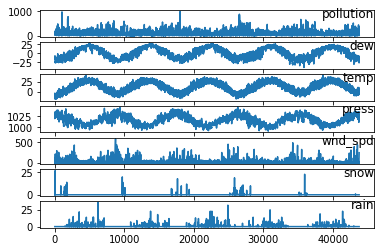

In [5]:
from matplotlib import pyplot
%matplotlib inline 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    #n_in number of lag observations
    #n_out number of next observations
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [40]:
#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from numpy import concatenate
from pandas import DataFrame
from pandas import concat
encoder =LabelEncoder()
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
#encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [8]:
reframed = series_to_supervised(scaled, 5, 3)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-5)  var2(t-5)  var3(t-5)  var4(t-5)  var5(t-5)  var6(t-5)  \
5   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
6   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
7   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
8   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
9   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-5)  var8(t-5)  var1(t-4)  var2(t-4)    ...      var7(t+1)  \
5   0.000000        0.0   0.148893   0.367647    ...       0.148148   
6   0.000000        0.0   0.159960   0.426471    ...       0.000000   
7   0.000000        0.0   0.182093   0.485294    ...       0.000000   
8   0.037037        0.0   0.138833   0.485294    ...       0.000000   
9   0.074074        0.0   0.109658   0.485294    ...       0.037037   

   var8(t+1)  var1(t+2)  var2(t+2)  var3(t+2)  var4(t+2)  var5(t+2)  \
5        0.0   0.124748   0.485294   0.229508   0.600000   0.666667   
6   

In [41]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.090543   0.485294   0.213115   0.654547   0.666667   0.099308   
2   0.063380   0.470588   0.213115   0.636364   0.666667   0.104657   
3   0.065392   0.470588   0.196721   0.636364   0.666667   0.111527   
4   0.055332   0.470588   0.196721   0.618183   0.666667   0.116876   
5   0.065392   0.470588   0.196721   0.600000   0.666667   0.123746   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.148148        0.0  0.063380  
2   0.185185        0.0  0.065392  
3   0.222222        0.0  0.055332  
4   0.259259        0.0  0.065392  
5   0.296296        0.0  0.083501  


In [42]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35015, 1, 8) (35015,)


In [11]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [43]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


Train on 8760 samples, validate on 35015 samples
Epoch 1/50
 - 6s - loss: 0.0514 - val_loss: 0.0505
Epoch 2/50
 - 4s - loss: 0.0338 - val_loss: 0.0555
Epoch 3/50
 - 4s - loss: 0.0203 - val_loss: 0.0473
Epoch 4/50
 - 4s - loss: 0.0166 - val_loss: 0.0360
Epoch 5/50
 - 4s - loss: 0.0154 - val_loss: 0.0240
Epoch 6/50
 - 4s - loss: 0.0150 - val_loss: 0.0211
Epoch 7/50
 - 4s - loss: 0.0147 - val_loss: 0.0186
Epoch 8/50
 - 4s - loss: 0.0147 - val_loss: 0.0169
Epoch 9/50
 - 5s - loss: 0.0146 - val_loss: 0.0156
Epoch 10/50
 - 4s - loss: 0.0145 - val_loss: 0.0159
Epoch 11/50
 - 4s - loss: 0.0145 - val_loss: 0.0147
Epoch 12/50
 - 4s - loss: 0.0143 - val_loss: 0.0157
Epoch 13/50
 - 5s - loss: 0.0145 - val_loss: 0.0163
Epoch 14/50
 - 5s - loss: 0.0146 - val_loss: 0.0144
Epoch 15/50
 - 5s - loss: 0.0143 - val_loss: 0.0152
Epoch 16/50
 - 5s - loss: 0.0144 - val_loss: 0.0163
Epoch 17/50
 - 5s - loss: 0.0144 - val_loss: 0.0156
Epoch 18/50
 - 4s - loss: 0.0143 - val_loss: 0.0156
Epoch 19/50
 - 5s - loss

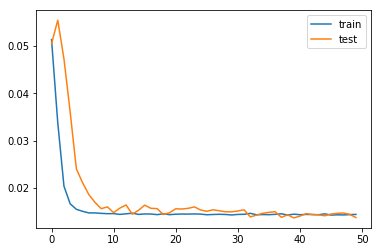

In [44]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [45]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.542


# using Multiple Lag Timesteps 

In [20]:
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

print(reframed.shape)

(43797, 32)


In [21]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)


(8760, 24) 8760 (8760,)


In [22]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)


Train on 8760 samples, validate on 35037 samples
Epoch 1/50
 - 8s - loss: 0.0436 - val_loss: 0.0795
Epoch 2/50
 - 7s - loss: 0.0255 - val_loss: 0.0484
Epoch 3/50
 - 7s - loss: 0.0215 - val_loss: 0.0307
Epoch 4/50
 - 8s - loss: 0.0210 - val_loss: 0.0270
Epoch 5/50
 - 7s - loss: 0.0202 - val_loss: 0.0242
Epoch 6/50
 - 7s - loss: 0.0199 - val_loss: 0.0209
Epoch 7/50
 - 7s - loss: 0.0194 - val_loss: 0.0197
Epoch 8/50
 - 8s - loss: 0.0190 - val_loss: 0.0185
Epoch 9/50
 - 7s - loss: 0.0184 - val_loss: 0.0181
Epoch 10/50
 - 8s - loss: 0.0181 - val_loss: 0.0174
Epoch 11/50
 - 7s - loss: 0.0175 - val_loss: 0.0176
Epoch 12/50
 - 6s - loss: 0.0172 - val_loss: 0.0182
Epoch 13/50
 - 6s - loss: 0.0168 - val_loss: 0.0183
Epoch 14/50
 - 7s - loss: 0.0164 - val_loss: 0.0174
Epoch 15/50
 - 7s - loss: 0.0160 - val_loss: 0.0168
Epoch 16/50
 - 7s - loss: 0.0157 - val_loss: 0.0169
Epoch 17/50
 - 7s - loss: 0.0153 - val_loss: 0.0176
Epoch 18/50
 - 7s - loss: 0.0150 - val_loss: 0.0178
Epoch 19/50
 - 7s - loss

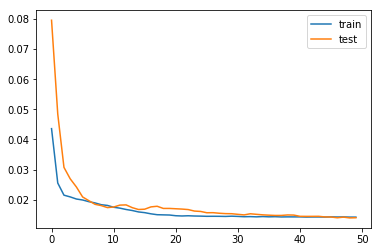

In [23]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                11800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [25]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.543
